In [3]:
import pandas as pd
import numpy as np
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## 1. 데이터 로드

In [85]:
# train set
newsdata = fetch_20newsgroups(subset = 'train')

### `-` 데이터 속성 확인하기

In [86]:
print(newsdata.keys())

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])


In [87]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))

훈련용 샘플의 개수 : 11314


In [88]:
num_labels = len(newsdata.target_names)
print('총 주제의 개수 : {}'.format(num_labels))
print(newsdata.target_names)

총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [89]:
newsdata.target, len(newsdata.target)

(array([7, 4, 4, ..., 3, 1, 8]), 11314)

In [90]:
print('첫번째 샘플의 레이블 : {}'.format(newsdata.target[0]))

첫번째 샘플의 레이블 : 7


In [91]:
print(newsdata.data[0]) # 첫번째 샘플 출력

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







# 2. 데이터 탐색

In [92]:
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [93]:
data['target'].value_counts()

10    600
15    599
8     598
9     597
11    595
7     594
13    594
5     593
14    593
2     591
12    591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
Name: target, dtype: int64

In [94]:
print('결측값 여부:', data.isnull().values.any())

결측값 여부: False


In [95]:
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


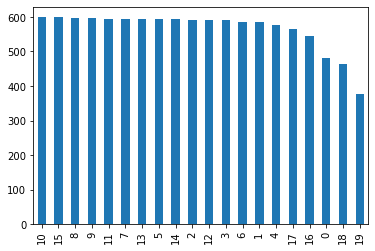

In [96]:
data['target'].value_counts().plot(kind='bar')

# 3. `X`데이터와 `y`데이터 분리

In [97]:
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

In [98]:
print('e-mail 첫번째 샘플 출력 :')
print(train_email[0])
print('========================')
print('e-mail 첫번째 샘플 레이블 :')
print(train_label[0])

e-mail 첫번째 샘플 출력 :
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





e-mail 첫번째 샘플 레이블 :
7


# 4. TF-IDF를 위한 전처리

In [99]:
vocab_size = 10000

In [100]:
tfidf_vect = TfidfVectorizer(max_features=vocab_size)
train_tfidf_list = tfidf_vect.fit_transform(train_email).toarray().tolist()
test_tfidf_list = tfidf_vect.transform(test_email).toarray().tolist()

In [101]:
train_tfidf_tensor = torch.tensor(train_tfidf_list)
train_label_tensor = torch.tensor(train_label)

test_tfidf_tensor = torch.tensor(test_tfidf_list)
test_label_tensor = torch.tensor(test_label)

In [102]:
print(train_tfidf_tensor.shape)
print(train_label_tensor.shape)
print(test_tfidf_tensor.shape)
print(test_label_tensor.shape)

torch.Size([11314, 10000])
torch.Size([11314])
torch.Size([7532, 10000])
torch.Size([7532])


# 5. 다층 퍼셉트론 설계

In [103]:
from torch import nn

class Perceptron(nn.Module):
    def __init__(self, tfidf_size, num_label):
        super(Perceptron, self).__init__()
        self.linear1 = nn.Linear(tfidf_size, 1400)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1400, num_label)

    def forward(self, tfidf_input):
        hidden = self.linear1(tfidf_input)
        relu = self.relu(hidden)
        y_pred = self.linear2(relu)
        return y_pred

In [104]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Perceptron(tfidf_size=vocab_size, num_label=num_labels)
model.to(device)

Perceptron(
  (linear1): Linear(in_features=10000, out_features=1400, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=1400, out_features=20, bias=True)
)

# 6. 손실 함수

In [105]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 7. 데이터 로더

In [106]:
train_dataset = torch.utils.data.TensorDataset(train_tfidf_tensor, train_label_tensor)
test_dataset = torch.utils.data.TensorDataset(test_tfidf_tensor, test_label_tensor)

In [107]:
train_DataLoader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=4)
test_DataLoader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=1)

### `-` train

In [108]:
for batch in train_DataLoader:
    batch = tuple(t.to(device) for t in batch)
    #print(batch[0])

In [ ]:
model.train(True)
model.zero_grad()

for epoch in range(5):
    epoch_loss = 0
    for batch in train_DataLoader:
        # batch (tf_idf_data, label)
        batch = tuple(t.to(device) for t in batch)

        y_pred = model(batch[0])
        loss = criterion(y_pred, batch[1])
        epoch_loss += loss.item()

        loss.backward()
        optimizer.step()
        model.zero_grad()
        
    print(epoch, epoch_loss)
model.train(False)